In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split

# Tratamento


In [ ]:
df_train = pd.read_csv('/content/train.csv')
df_test = pd.read_csv('/content/test.csv')

In [ ]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_binario
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


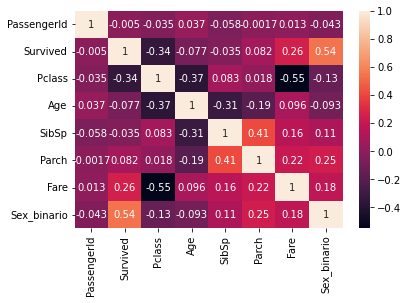

In [ ]:
sns.heatmap(df_train.corr(), annot=True);

In [ ]:
def transformar_sexo(valor):
  if valor == 'female':
    return 1
  else:
    return 0

df_train['Sex_binario'] = df_train['Sex'].map(transformar_sexo)
df_test['Sex_binario'] = df_test['Sex'].map(transformar_sexo)

In [ ]:
variaveis = ['Sex_binario', 'Age', 'Fare', 'Parch', 'Pclass', 'SibSp']

In [ ]:
x = df_train[variaveis]
y = df_train['Survived']

In [ ]:
x.isnull().sum()

Sex_binario    0
Age            0
Fare           0
Parch          0
Pclass         0
SibSp          0
dtype: int64

In [ ]:
x['Age'].fillna(x['Age'].mean(), inplace=True)

In [ ]:
x_prev = df_test[variaveis]

In [ ]:
x_prev.isnull().sum()

Sex_binario     0
Age            86
Fare            1
Parch           0
Pclass          0
SibSp           0
dtype: int64

In [ ]:
x_prev['Age'].fillna(x_prev['Age'].mean(), inplace=True)

In [ ]:
x_prev['Fare'].fillna(x_prev['Fare'].mean(), inplace=True)

In [ ]:
x_prev.isnull().sum()

Sex_binario    0
Age            0
Fare           0
Parch          0
Pclass         0
SibSp          0
dtype: int64

In [ ]:
x_treinamento, x_teste, y_treinamento, y_teste = train_test_split(x, y, test_size = 0.25, random_state = 0)

In [ ]:
x_treinamento.shape, y_treinamento.shape, x_teste.shape, y_teste.shape

((668, 6), (668,), (223, 6), (223,))

In [ ]:
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
scaler_x = preprocessing.StandardScaler().fit(x)
scaler_x_prev = preprocessing.StandardScaler().fit(x_prev)

x_treinamento = scaler_x.transform(x_treinamento)
x_teste = scaler_x.transform(x_teste)
x_prev_scaled = scaler_x.transform(x_prev)

In [ ]:
x_treinamento.shape, y_treinamento.shape, x_teste.shape, y_teste.shape, x_prev_scaled.shape

((668, 6), (668,), (223, 6), (223,), (418, 6))

In [ ]:
x_treinamento.shape, y_treinamento.shape, x_teste.shape, y_teste.shape, x_prev_scaled.shape

((668, 6), (668, 1), (223, 6), (223, 1), (418, 6))

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
modelo = RandomForestClassifier(criterion='entropy', min_samples_leaf=1, min_samples_split=10, n_estimators=150)

In [ ]:
modelo.fit(x_treinamento, y_treinamento)

RandomForestClassifier(criterion='entropy', min_samples_split=10,
                       n_estimators=150)

In [ ]:
previsoes = modelo.predict(x_teste) #x_prev = 76.79%

In [ ]:
accuracy_score(y_teste, previsoes)

0.8565022421524664

In [ ]:
resposta = pd.Series(previsoes,index=df_test['PassengerId'], name='Survived');

In [ ]:
resposta.to_csv('titanic_random_forest_scaledV4.csv', header=True)

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
parametros_randomforest = {
              'criterion': ['gini', 'entropy'],
              'n_estimators': [10,40,100,150],
              'min_samples_split': [2,5,10,50],
              'min_samples_leaf': [1,5,10,50]
              }

In [ ]:
grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=parametros_randomforest)
grid_search.fit(x_treinamento, y_treinamento)
print(grid_search.best_params_, grid_search.best_score_)
#{'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 10} 0.8092272926997678
#{'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100} 0.8126043562864854
#{'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 150} 0.8373171803402171
#{'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 150} 0.8384407758458352
#{'criterion': 'gini', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 150} 0.827864437212434


{'criterion': 'gini', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 150} 0.827864437212434


In [ ]:
from sklearn.model_selection import cross_val_score, KFold

In [ ]:
resultado_random_forest = []
for i in range(30):
  kfold = KFold(n_splits=10, shuffle=True, random_state=i)
  random_forest = RandomForestClassifier(criterion='gini', min_samples_leaf=1, min_samples_split=10, n_estimators=10)
  score = cross_val_score(random_forest, x_scaled,y,cv=kfold)
  resultado_random_forest.append(score.mean())

In [ ]:
resultado_random_forest = pd.DataFrame({'Random Forest': resultado_random_forest})

In [ ]:
resultado_random_forest.describe()

,Random Forest
count,30.000000
mean,0.793495
std,0.007273
min,0.777740
25%,0.788727
50%,0.793533
75%,0.797400
max,0.811511


# RNA

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
parametros_rna = {
    'activation': ['relu', 'logistic', 'tanh', 'identity'],
    'solver': ['adam', 'sgd', 'lbfgs'],
    'batch_size': [10, 56],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'max_iter': [200,500,1000]
}

In [ ]:
grid_search = GridSearchCV(estimator=MLPClassifier(), param_grid=parametros_rna)
grid_search.fit(x_scaled,y)
print(grid_search.best_params_, grid_search.best_score_)
#{'activation': 'logistic', 'batch_size': 10, 'learning_rate': 'adaptive', 'max_iter': 1000, 'solver': 'lbfgs'} 0.7990772707300233
#{'activation': 'relu', 'batch_size': 56, 'learning_rate': 'adaptive', 'max_iter': 1000, 'solver': 'adam'} 0.7979787835038604
#{'activation': 'relu', 'batch_size': 56, 'learning_rate': 'adaptive', 'max_iter': 200, 'solver': 'adam'} 0.7923859142552258


In [ ]:
modelo_rna = MLPClassifier(activation='logistic', batch_size=10, learning_rate='adaptive', max_iter=1000, solver='lbfgs', hidden_layer_sizes=(3,3))

In [ ]:
modelo_rna.fit(x_scaled,y)

MLPClassifier(activation='logistic', batch_size=10, hidden_layer_sizes=(3, 3),
              learning_rate='adaptive', max_iter=1000, solver='lbfgs')

In [ ]:
previsoes_rna = modelo_rna.predict(x_prev_scaled)

In [ ]:
resposta_rna = pd.Series(previsoes_rna,index=df_test['PassengerId'], name='Survived');

In [ ]:
resposta_rna.to_csv('titanic_rna.csv', header=True)

# kNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
parametros_knn = {
    'p': [1,2],
    'n_neighbors': [3,5,10,20],
    'weights': ['uniform', 'distance'],
    'leaf_size': [10,20,30,40,50]
}

In [ ]:
grid_search = GridSearchCV(estimator=KNeighborsClassifier(n_jobs=-1), param_grid=parametros_knn)
grid_search.fit(x_scaled, y)
print(grid_search.best_params_, grid_search.best_score_)
#
#{'n_neighbors': 5, 'p': 1, 'weights': 'uniform'} 0.7834285355596008
#{'leaf_size': 10, 'n_neighbors': 20, 'p': 1, 'weights': 'uniform'} 0.7811374050593184


{'leaf_size': 10, 'n_neighbors': 20, 'p': 1, 'weights': 'uniform'} 0.7811374050593184


# SVM

In [ ]:
from sklearn.svm import SVC

In [ ]:
parametros_svm = {
    'tol': [0.001, 0.0001, 0.00001],
    'C': [1.0, 1.5, 2.0],
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
    'degree': [1,2,3,4,5],
    'gamma': ['scale', 'auto']
}

In [ ]:
grid_search = GridSearchCV(estimator=SVC(), param_grid=parametros_svm)
grid_search.fit(x_scaled, y)
print(grid_search.best_params_, grid_search.best_score_)
#
#{'C': 1.0, 'degree': 1, 'gamma': 'auto', 'kernel': 'rbf', 'tol': 0.0001} 0.7923608059757706
#{'C': 1.5, 'degree': 1, 'gamma': 'scale', 'kernel': 'rbf', 'tol': 0.001} 0.7979787835038604


{'C': 1.5, 'degree': 1, 'gamma': 'scale', 'kernel': 'rbf', 'tol': 0.001} 0.7979787835038604


# Rede Neural com Tensorflow

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.xlabel('Epoch')
  plt.ylabel('Binary crossentropy')
  plt.legend()
  plt.grid(True)
  plt.show()

def plot_accuracy(history):
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.grid(True)
  plt.show()

In [ ]:
def train_model(x, y, num_nodes, dropout_prob, lr, bs, epochs):
  nn_model = tf.keras.Sequential([
      tf.keras.layers.Dense(num_nodes, activation='relu'),
      tf.keras.layers.Dropout(dropout_prob),
      tf.keras.layers.Dense(num_nodes, activation='relu'),
      tf.keras.layers.Dropout(dropout_prob),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])
  nn_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])
  history = nn_model.fit(x,y, epochs=epochs, batch_size=bs)
  return nn_model, history

In [ ]:
epochs=100
for num_nodes in [32,64,128]:
  for dropout_prob in [0, 0.1, 0.2]:
    for lr in [0.001, 0.0001, 0.00001]:
      for bs in [32, 64, 128]:
        print(f"{num_nodes} nodes, dropout{dropout_prob}, lr{lr}, bs{bs}")
        model, history = train_model(x_scaled, y, num_nodes, dropout_prob, lr, bs, epochs)

In [ ]:
previsoes_tf = nn_model.predict(x_prev_scaled)

14/14 [==============================] - 0s 4ms/step


In [ ]:
previsoes_tf = (previsoes_tf > 0.5).astype(int).reshape(-1)

In [ ]:
resposta_tf = pd.Series(previsoes_tf,index=df_test['PassengerId'], name='Survived');

In [ ]:
resposta_tf.to_csv('titanic_tf.csv', header=True)